# This project is for a closed competition hosted by Google to create a movie recommender system based on an IMDB datset. 
## Team: HappyMiners_LA
### Team Members: 
- #### Blessing Nwogu
- #### Diana Castillo
- #### Gila Kohanbash
- #### Rachel Finley
#### This notebook was authored by Rachel Finley
references: 
- https://www.kaggle.com/code/serigne/stacked-regressions-top-4-on-leaderboard
- https://www.kaggle.com/code/pmarcelino/comprehensive-data-exploration-with-python/notebook
- @misc{breakthrough-tech-ai-studio-challenge,
    author = {Christian McIntire, Hari Raghavan, Ilan Bigio, Ilan Bigio Personal, inversion, Mango Vemulapati, Paul Stephenson, Saritajoshi-google, Stephanie Gomez, Walter Reade},
    title = {BTTAI x Google Spring 2023 AI Studio Competition},
    publisher = {Kaggle},
    year = {2023},
    url = {https://kaggle.com/competitions/breakthrough-tech-ai-studio-challenge}
}

# Import Libraries
begin with neccesary imports

In [1]:
#import some necessary librairies

# Standard Linalg and Data Processing Libs
import numpy as np 
import pandas as pd 

# Matlab-style plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

# Ignore annoying warnings (from sklearn and seaborn)
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn 

# For some statistics
from scipy import stats
from scipy.stats import norm, skew 

# Limiting floats in Pandas output to 3 decimal points
pd.set_option('display.float_format', lambda x: '{:.3}'.format(x)) 

# Nice libraries for the initial data cleanup that we need to do
import ast
import re 

# Having a progress bar where applicable is always a plus!
import time
from tqdm.notebook import tqdm_notebook as tqdm

from sklearn.preprocessing import LabelEncoder


# Initial Prep, EDA, Data Cleanup, and Preprocessing

## Loading in and cleaning up the files given by competition.
We were provided with 4 csv files separated into two categories:
- #### Product Information
- Metadata
- Keywords
- #### User Information
- Train
- Test

There is an IMDB movie ID that links the product data and user data. All we have as far as User information goes is the aforementioned movie ID and a User ID. 
There is lots of nested data within the Metadata and Keywords files that we will have to extract to make use of their features. I am going to begin with that task before moving on to EDA.

### Metadata Initial Cleanup

#### I've gone and inspected the CSV files already, and we will need to extract the information from: belongs to collection, genres, spoken languages, and production companies. 
##### NOTE: I had already created these functions separately beforehand at the beginning of this competition.

In [2]:
def expand_production_studio_id(df):
    '''Function to expand production studio IDs from a column containing a list of dictionaries'''
    
    # Creating a new column for the production studio ID
    df['production_studio_id'] = ''
    
    # Iterating through the dataframe with the itertuples method, which is faster than iterrows
    for row in tqdm(df.itertuples(), desc = 'Production Studio'):
        
        # Checking if the production_companies value is NaN
        if pd.isna(row.production_companies):
            continue
        
        # Using ast to parse the stringified list of dictionaries
        studio_data = ast.literal_eval(row.production_companies)
        
        # Extracting the ID of the first production studio
        if len(studio_data) > 0:
            studio_id = studio_data[0]['id']
        else:
            studio_id = ''
        
        # Setting the production studio ID for the current row
        df.at[row.Index, 'production_studio_id'] = studio_id
        
    # Dropping the original column containing the list of dictionaries
    df.drop(columns=['production_companies'], inplace=True)
    
    # Returning the expanded dataframe
    return df

In [3]:
def expand_production_country(df):
    '''Function to extract production country from a column containing a list of dictionaries'''
    
    # Creating a new column for the production country
    df['production_country'] = ''
    
    # Iterating through the dataframe with the itertuples method, which is faster than iterrows
    for row in tqdm(df.itertuples(), desc = 'Production Country'):
        
        # Checking if the production_countries value is NaN
        if pd.isna(row.production_countries):
            continue
        
        # Using ast to parse the stringified list of dictionaries
        country_data = ast.literal_eval(row.production_countries)
        
        # Extracting the iso_3166_1 value from the first dictionary
        if len(country_data) > 0:
            country_iso = country_data[0]['iso_3166_1']
        else:
            country_iso = ''
        
        # Setting the production country for the current row
        df.at[row.Index, 'production_country'] = country_iso
        
    # Dropping the original column containing the list of dictionaries
    df.drop(columns=['production_countries'], inplace=True)
    
    # Returning the expanded dataframe
    return df


In [4]:
def expand_spoken_languages(df):
    '''Function to extract spoken languages from a column containing a list of dictionaries'''
    
    # Creating a new column for the spoken languages
    df['spoken_language'] = ''
    
    # Iterating through the dataframe with the itertuples method, which is faster than iterrows
    for row in tqdm(df.itertuples(),  desc = 'Spoken Languages'):
        
        # Checking if the spoken_languages value is NaN
        if pd.isna(row.spoken_languages):
            continue
        
        # Using ast to parse the stringified list of dictionaries
        language_data = ast.literal_eval(row.spoken_languages)
        
        # Extracting the iso_639_1 value from the first dictionary
        if len(language_data) > 0:
            language_iso = language_data[0]['iso_639_1']
        else:
            language_iso = ''
        
        # Setting the spoken language for the current row
        df.at[row.Index, 'spoken_language'] = language_iso
        
    # Dropping the original column containing the list of dictionaries
    df.drop(columns=['spoken_languages'], inplace=True)
    
    # Returning the expanded dataframe
    return df

In [5]:
def retrieve_nested_data_metadata(df):
    '''Function to Retrieve the nested data in the Metadata file'''
    
    # Creating column names to account for the amount of sub-categories within each entry
    col_names = ['genre_id_1', 'genre_name_1',
                 'genre_id_2', 'genre_name_2', 
                 'genre_id_3', 'genre_name_3', 
                 'genre_id_4', 'genre_name_4', 
                 'genre_id_5', 'genre_name_5', 
                 'genre_id_6', 'genre_name_6', 
                 'genre_id_7', 'genre_name_7',
                 'genre_id_8', 'genre_name_8']
    
    # Adding those columns to the dataframe
    df = df.reindex(columns = df.columns.tolist() + col_names)
    
    # Iterating through the dataframe with the iterrows method (its kinda like enumerate for DF's), 
    # using tqdm as a timer. Index from the "enumeration" is helpful for multi-indexing later.
    for index, row in tqdm(df.iterrows(), desc = 'Genres'):
        
        # Using ast library to evaluate a string formatted as a dictionary, which basically typecasts. 
        ## ast library works better than python's eval method IMO.
        genre_data = ast.literal_eval(row[3])
        
        # Using enumerate here to be able to perform efficient multi-indexing.
        for counter, dictionary in enumerate(genre_data, start = 1):
            
            # By using a dict based for loop, and if/else block makes this multi-indexing easier, and allows
            # for us to easily assign values to DF rows based on our conditional. NOTE: df.loc is the best
            # way to multi-index through a DF that I have found. (had errors trying to use list-like multi-indexing,
            # (ie) df['col']['index'])
            for key, value in dictionary.items():
                if key == 'id':
                    df.loc[index, f'genre_id_{counter}'] = value

                elif key == 'name':
                    df.loc[index, f'genre_name_{counter}'] = value

    # Creating column names to account for the amount of sub-categories within each entry
    col_names = ['collection_id', 'part_of_collection']
    
    # Adding those columns to the dataframe
    df = df.reindex(columns = df.columns.tolist() + col_names)
    
    # Iterating through the dataframe with the iterrows method, using tqdm as a timer. Don't need to multi-index this time.
    for index, row in tqdm(df.iterrows(), desc = 'Belongs to Collection'):
        
        # Using a try/ except suite since ast's eval methods throw an error for the various NaN entries in the column.
        try:
            
            # Using ast library to evaluate a string formatted as a dictionary, which basically typecasts. 
            ## ast library works better than python's eval method IMO.
            collection_data = ast.literal_eval(row[1])
            
            # Same idea here with the key, value for loop, making it easier to assign specific cells.
            for key, value in collection_data.items():
   
                if key == 'id':
                    df.loc[index, 'collection_id'] = value

                elif key == 'name':
                    df.loc[index, 'part_of_collection'] = value
        
        # Here the pass statement is just making it so that we skip over each row with NaN values
        except ValueError:
            pass
    
    # Drop original nested columns
    to_drop = ['belongs_to_collection', 'genres']
    df.drop(columns = to_drop, inplace = True)
        
    # Here the other three functions created at other times get implemented.
    df = expand_production_studio_id(df)
    df = expand_production_country(df)
    df = expand_spoken_languages(df)
    
    # Drop Columns useless to our final product.
    to_drop_2 = ['imdb_id', 'homepage', 'poster_path']
    df.drop(columns = to_drop_2, inplace = True)
    
    # Rename id to movieId to match user data
    df = df.rename(columns = {"id": "movieId"})
    
    # Returning our expanded dataframe!
    return df

#### Load in and expand out the metadata from the CSV file

In [6]:
metadata = pd.read_csv("movies_metadata.csv", encoding = 'utf-8')

metadata = retrieve_nested_data_metadata(metadata)
metadata.head(1)

Genres: 0it [00:00, ?it/s]

Belongs to Collection: 0it [00:00, ?it/s]

Production Studio: 0it [00:00, ?it/s]

Production Country: 0it [00:00, ?it/s]

Spoken Languages: 0it [00:00, ?it/s]

,adult,budget,movieId,original_language,original_title,overview,popularity,release_date,revenue,runtime,...,genre_name_6,genre_id_7,genre_name_7,genre_id_8,genre_name_8,collection_id,part_of_collection,production_studio_id,production_country,spoken_language
0,False,30000000,1,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9,1995-10-30,3.74e+08,81.0,...,NaN,NaN,NaN,NaN,NaN,1.02e+04,Toy Story Collection,3,US,en


### Metadata Initial EDA

#### Check for missing data!
First things first, lets check for missing data before moving unto more complex tasks.

In [7]:
#missing data
total = metadata.isnull().sum().sort_values(ascending = True)
percent = (metadata.isnull().sum() / metadata.isnull().count()).sort_values(ascending = True)
missing_data = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
print(f'Inital Size of Metadata: {metadata.shape}')
missing_data

Inital Size of Metadata: (45383, 37)


,Total,Percent
adult,0,0.0
production_studio_id,0,0.0
production_country,0,0.0
original_title,0,0.0
spoken_language,0,0.0
budget,0,0.0
movieId,0,0.0
popularity,3,6.61e-05
revenue,3,6.61e-05
title,3,6.61e-05


- Lets Visualize the NaN values

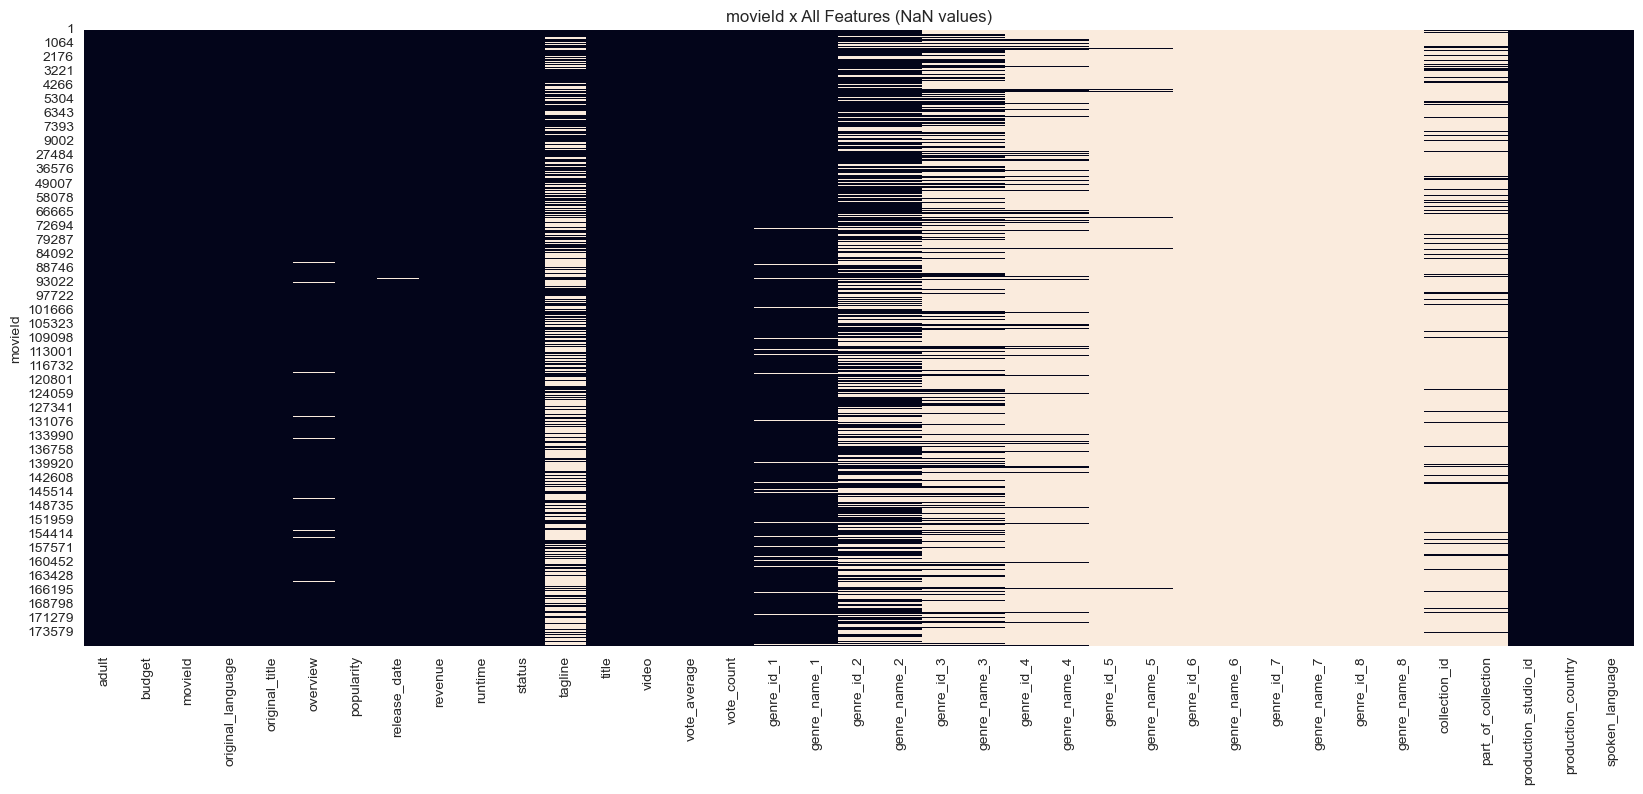

In [8]:
# Create a binary DataFrame where 1 indicates a NaN value and 0 indicates a non-NaN value
binary_nan_metadata = metadata.isnull().astype(int)

# Create the heatmap with 'movieId' as y-axis values and showing the color legend
fig, ax = plt.subplots(figsize=(20, 8))
sns.heatmap(binary_nan_metadata.set_index(metadata['movieId']), cbar = False, ax = ax).set_title("movieId x All Features (NaN values)")
ax.set_ylabel('movieId')
plt.show()

- Here, all of the NaN-values are the beige color. A lot of these results are confirming my basic theories. Most of the missing data comes from the text data as well as the categorical data.
- There's not too much we can can do in the way of imputing these NaN-Values. Possibly testing various embedding techniques + truncation, then using various imputing techniques before checking label correlation
- I am going to test using just one of the genre columns with label encoding vs combining the text data, creating a TFIDF, and truncating it to one column; then I will compare correlation with the label.
- Also, going to run a test with keeping genres as one-hot encoded features, and dropping n-number of columns.

#### An exploration of just NaN values could be misleading. Lets check for zero values as well!
- I am going to change release date into a release year column as well

In [9]:
# getting rid of the day/ month parts of the release_date column, then adding padding
metadata['release_date'] = metadata['release_date'].astype(str).apply(lambda x: re.sub('[\-]\d\d[\-]\d\d', '', x).strip())
metadata['release_date'] = metadata['release_date'].astype(str).apply(lambda x: re.sub('nan', '0', x).strip())
metadata['release_date'] = metadata['release_date'].astype(int)
metadata = metadata.rename(columns = {'release_date' : 'release_year'})

- Create a function for counting the amount of zeroes within a given list of columns of our dataframe

In [10]:
def count_percent_zeros(df, cols):
    total_zeros = (df[cols] == 0).sum().sort_values(ascending=False)
    percent_zeros = (total_zeros / df[cols].count()).sort_values(ascending=False)
    zero_data = pd.concat([total_zeros, percent_zeros], axis=1, keys=['Total', 'Percent'])
    return zero_data

In [11]:
# Print the initial size of metadata and the zero values information
print(f'Initial Size of Metadata: {metadata.shape}')
count_percent_zeros(metadata, metadata.columns)

Initial Size of Metadata: (45383, 37)


,Total,Percent
adult,45375,1.0
video,45287,0.998
revenue,37975,0.837
budget,36500,0.804
vote_average,2978,0.0656
vote_count,2879,0.0634
runtime,1548,0.0343
release_year,81,0.00178
popularity,63,0.00139
genre_name_5,0,0.0


- In an inital observation, I can see that both Video and Adult, which are binary values, skew almost entirely to 0. This is not going to have any benefit for us by way of adding predictability to the dataset, so I am going to go ahead and drop them.

In [12]:
metadata.drop(columns = ['adult', 'video'], inplace = True)

- Lets visualize our 0's

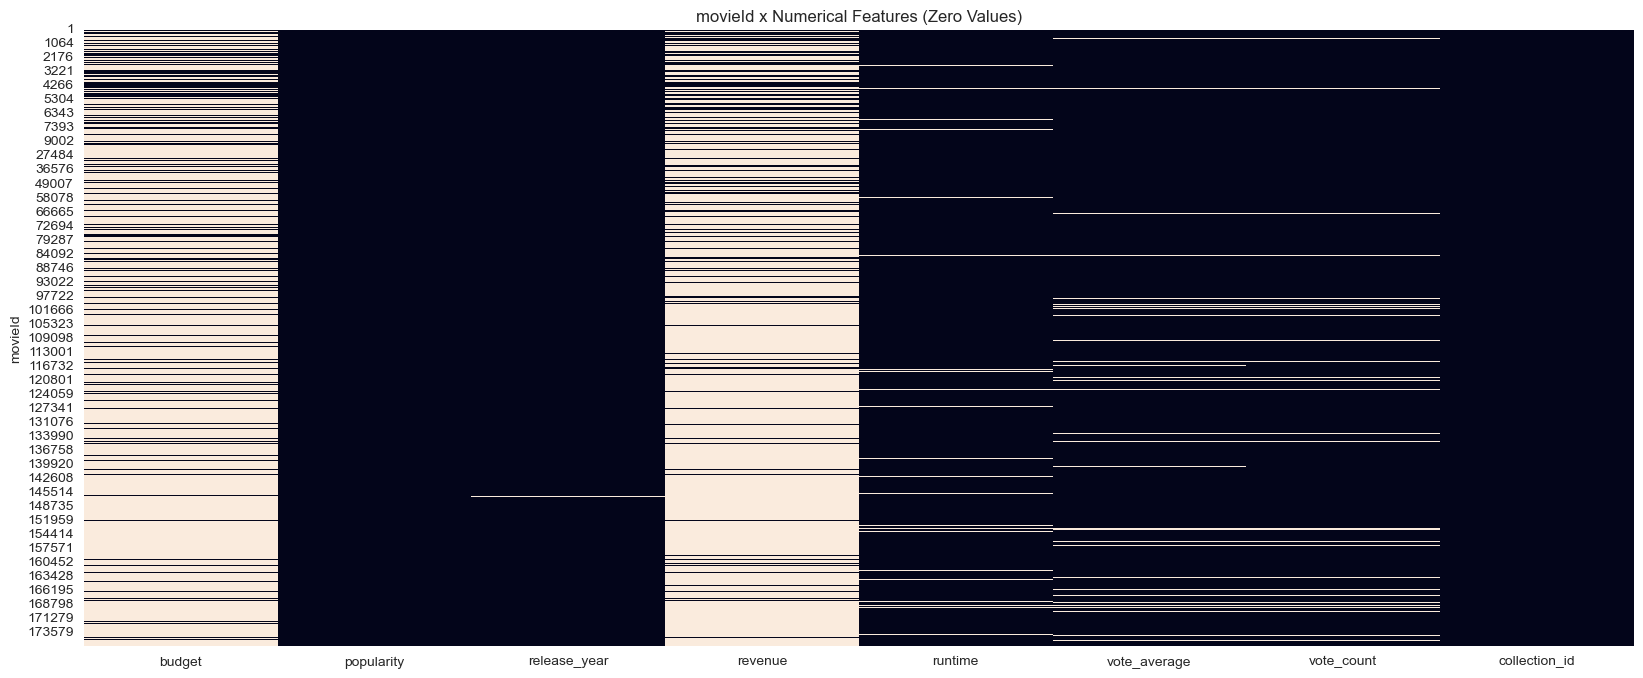

In [13]:
# Create a filtered DataFrame without the 'movieId' column
metadata_filtered = metadata.drop(columns=['movieId', 'genre_id_1', 'genre_id_2', 'genre_id_3',
                                           'genre_id_4', 'genre_id_5', 'genre_id_6', 'genre_id_7', 'genre_id_8'])

# Select only numeric columns from the filtered DataFrame
metadata_numeric = metadata_filtered.select_dtypes(include= [int,float])

# Create a binary DataFrame where 1 indicates a zero value and 0 indicates a non-zero value
binary_metadata = (metadata_numeric == 0)

# Create the heatmap with 'movieId' as y-axis values and showing the color legend
fig, ax = plt.subplots(figsize=(20, 8))
sns.heatmap(binary_metadata.set_index(metadata['movieId']), cbar = False, ax=ax).set_title("movieId x Numerical Features (Zero Values)")
ax.set_ylabel('movieId')
plt.show()

- Here again beige is an indicator of our missing values. (Considering 0 values as missing)
- I am going to begin by imputing budget and revenue  with their mean values based on the release year
- Then, fill the rest of the year columns with mean year based on budget.
- In all of the tests I had run, that was the best hueristic. The initial notion was to impute the data in a way that adjusted for inflation.
- I will test correlation between popularity and vote_count and vote_average as well as other variables to see which is the best way to fill the data

- It is my opinion that the best way to start would be to handle outliers, and then impute values

#### Imputing Budget, Revenue, and Release Year

In [14]:
cols = ['budget', 'revenue', 'release_year']
count_percent_zeros(metadata, cols)

,Total,Percent
revenue,37975,0.837
budget,36500,0.804
release_year,81,0.00178


In [15]:
def replace_zero_with_average(df, col):
    '''Replace zero values in the budget column with the average budget for the given release year.'''

    # Calculate the average value for each release date
    avg = df.groupby('release_year')[col].mean()

    # Replace 0 values in the column with the average for that release year
    df[col] = df.apply(lambda row: row[col] if row[col] != 0 else avg[row['release_year']], axis = 1)

    return df

In [16]:
replace_zero_with_average(metadata, col = 'budget')
replace_zero_with_average(metadata, col = 'revenue')
metadata.head(1)

,budget,movieId,original_language,original_title,overview,popularity,release_year,revenue,runtime,status,...,genre_name_6,genre_id_7,genre_name_7,genre_id_8,genre_name_8,collection_id,part_of_collection,production_studio_id,production_country,spoken_language
0,3e+07,1,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9,1995,3.74e+08,81.0,Released,...,NaN,NaN,NaN,NaN,NaN,1.02e+04,Toy Story Collection,3,US,en


In [17]:
cols = ['budget', 'revenue']
count_percent_zeros(metadata, cols)

,Total,Percent
revenue,302,0.00665
budget,193,0.00425


- Fill the rest of the zeros with the mean of each column.

In [18]:
for col in cols:
    metadata[col] =  metadata[col].replace(0, metadata[col].mean())

In [19]:
cols = ['budget', 'revenue', 'release_year']
count_percent_zeros(metadata, cols)

,Total,Percent
release_year,81,0.00178
budget,0,0.0
revenue,0,0.0


- I wanted to replace missing release year values depending on the median release date for films with similar budgets, without success.
- After trying many different methods to no avail, I am just going to fill the remaining release year columns with the median year since the amount of 0 values is near in consequntial, but 0 is a serious outlier to values in the thousands.

In [20]:
metadata['release_year'] =  metadata['release_year'].replace(0, metadata['release_year'].median())

In [21]:
cols = ['budget', 'revenue', 'release_year']
count_percent_zeros(metadata, cols)

,Total,Percent
budget,0,0.0
revenue,0,0.0
release_year,0,0.0


#### Imputing Vote Average and Vote Count

- Now, for some tests to see which method would be the best method to replace missing or zero value vote average and vote count variables.
- We will do this using a heatmap to compare levels of correlation

In [22]:
cols = ['vote_count', 'vote_average']
count_percent_zeros(metadata, cols)

,Total,Percent
vote_average,2978,0.0656
vote_count,2879,0.0634


In [23]:
metadata.columns

Index(['budget', 'movieId', 'original_language', 'original_title', 'overview',
       'popularity', 'release_year', 'revenue', 'runtime', 'status', 'tagline',
       'title', 'vote_average', 'vote_count', 'genre_id_1', 'genre_name_1',
       'genre_id_2', 'genre_name_2', 'genre_id_3', 'genre_name_3',
       'genre_id_4', 'genre_name_4', 'genre_id_5', 'genre_name_5',
       'genre_id_6', 'genre_name_6', 'genre_id_7', 'genre_name_7',
       'genre_id_8', 'genre_name_8', 'collection_id', 'part_of_collection',
       'production_studio_id', 'production_country', 'spoken_language'],
      dtype='object')

In [24]:
metadata.budget

0          3e+07
1        6.5e+07
2       5.45e+06
3        1.6e+07
4       5.45e+06
          ...   
45378   1.07e+04
45379   5.85e+06
45380   7.36e+06
45381   7.45e+06
45382   9.03e+06
Name: budget, Length: 45383, dtype: float64

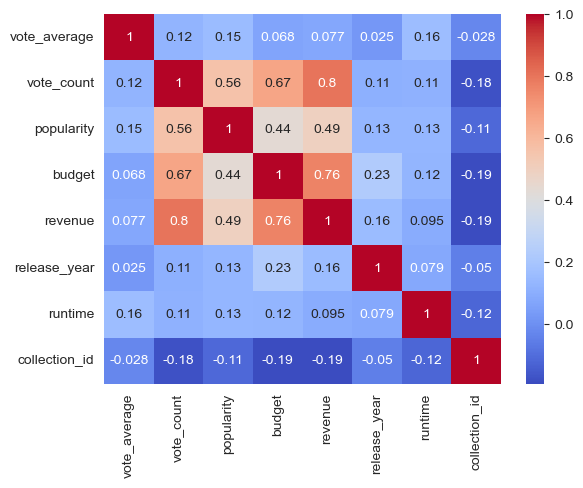

In [25]:
# Numerical Columns to check
cols = ['vote_average', 'vote_count', 'popularity', 'budget', 'revenue', 'release_year', 'runtime', 'collection_id']

# Calculate the pairwise correlation between columns
correlations = metadata[cols].corr()

# Create a heatmap to visualize the correlations
sns.heatmap(correlations, annot=True, cmap='coolwarm')
plt.show()

- I will start by imputing the vote count ("0") values with the median vote count grouped by revenues within a certain level of tolerance

In [26]:
def replace_zero_with_median(df, col_to_impute, col_for_median, tolerance):
    """Replace "0" values in the specified column with the median value for
    similar values in another specified column, within a certain level of tolerance. """

    # Calculate the median for the specified column for each value in the specified column
    median_values = df.groupby(col_for_median)[col_to_impute].median()

    # Function to find the closest value in the specified column to a given value within a certain range
    def find_closest_value(value):
        if tolerance is None:
            return median_values.index[median_values.index == value][0]
        else:
            filtered_values = median_values.index[(median_values.index >= (1 - tolerance) * value) &
                                                  (median_values.index <= (1 + tolerance) * value)]
            if len(filtered_values) == 0:
                return None
            return filtered_values[np.abs(filtered_values - value).argmin()]

    # Replace "0" values in the specified column with the median value for
    # similar values in the specified column
    df[col_to_impute] = df.apply(
        lambda row: row[col_to_impute] if row[col_to_impute] != 0 else median_values[find_closest_value(row[col_for_median])],
        axis=1
    )

    return df


In [27]:
metadata = replace_zero_with_median(metadata, 'vote_count', 'budget', tolerance = .1)
cols = ['vote_count', 'vote_average']
count_percent_zeros(metadata, cols)

,Total,Percent
vote_average,2978,0.0656
vote_count,60,0.00132


- Replace rest of vote counts with median of vote counts

In [28]:
metadata['vote_count'] = metadata['vote_count'].replace(0, metadata['vote_count'].median())

In [29]:
cols = ['vote_count', 'vote_average']
count_percent_zeros(metadata, cols)

,Total,Percent
vote_average,2978,0.0656
vote_count,0,0.0


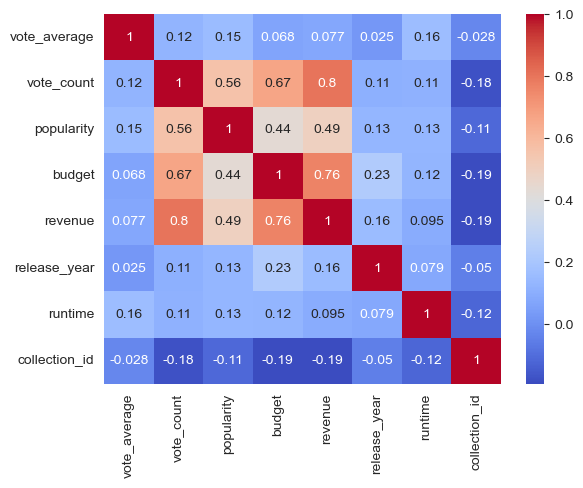

In [30]:
# Numerical Columns to check
cols = ['vote_average', 'vote_count', 'popularity', 'budget', 'revenue', 'release_year', 'runtime', 'collection_id']

# Calculate the pairwise correlation between columns
correlations = metadata[cols].corr()

# Create a heatmap to visualize the correlations
sns.heatmap(correlations, annot=True, cmap='coolwarm')
plt.show()

###### - Theory: All of the high Correlated variables here will end up being among the variables kept after using feature selection algorithms, making this into a problem with high co-linearity

In [31]:
metadata = replace_zero_with_median(metadata, 'vote_average', 'revenue', tolerance = .1)
cols = ['vote_count', 'vote_average']
count_percent_zeros(metadata, cols)

,Total,Percent
vote_average,78,0.00172
vote_count,0,0.0


In [32]:
metadata['vote_average'] = metadata['vote_average'].replace(0, metadata['vote_average'].median())
count_percent_zeros(metadata, cols)

,Total,Percent
vote_count,0,0.0
vote_average,0,0.0


### Do a quick check for remaining 0 values

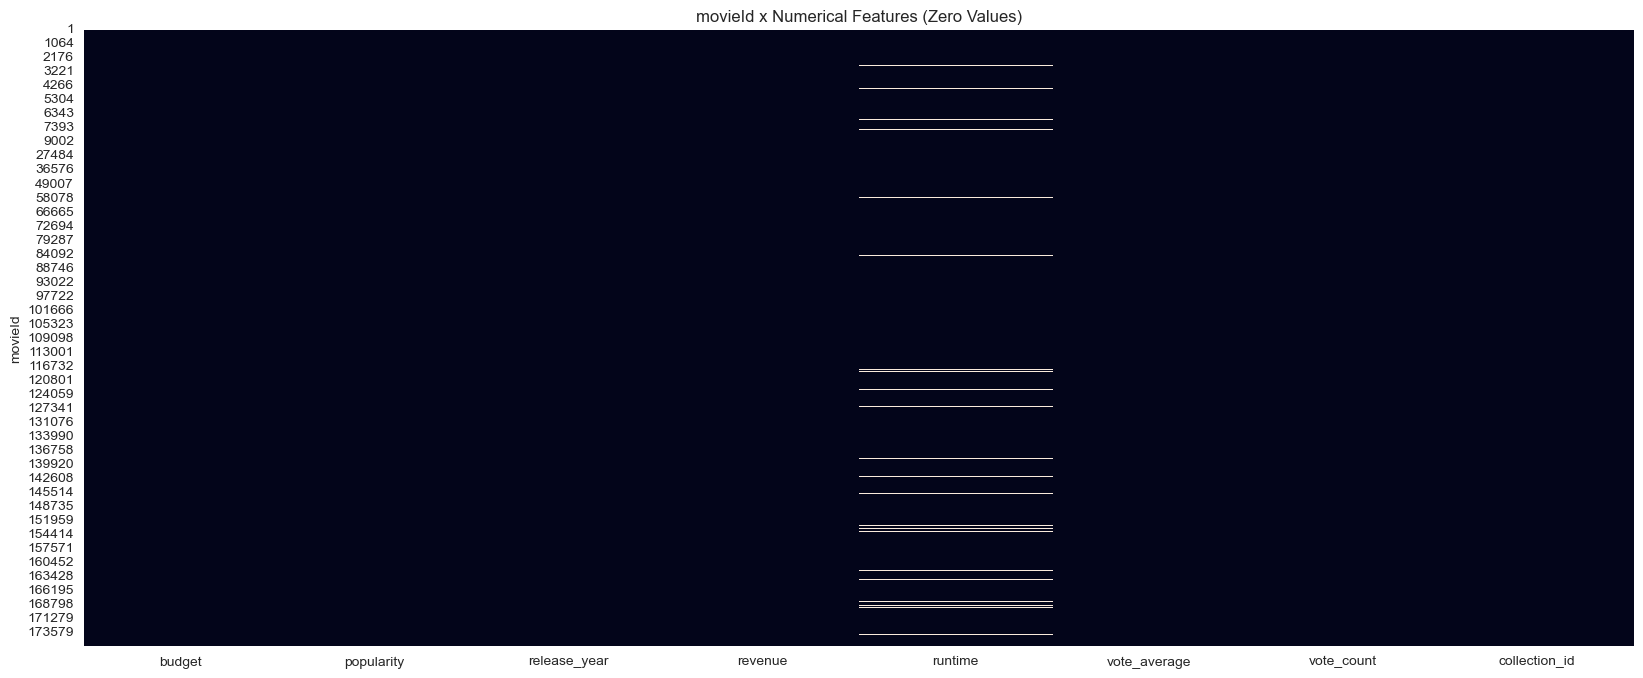

In [33]:
# Create a filtered DataFrame without the 'movieId' column
metadata_filtered = metadata.drop(columns=['movieId', 'genre_id_1', 'genre_id_2', 'genre_id_3',
                                           'genre_id_4', 'genre_id_5', 'genre_id_6', 'genre_id_7', 'genre_id_8'])

# Select only numeric columns from the filtered DataFrame
metadata_numeric = metadata_filtered.select_dtypes(include= [int,float])

# Create a binary DataFrame where 1 indicates a zero value and 0 indicates a non-zero value
binary_metadata = (metadata_numeric == 0)

# Create the heatmap with 'movieId' as y-axis values and showing the color legend
fig, ax = plt.subplots(figsize=(20, 8))
sns.heatmap(binary_metadata.set_index(metadata['movieId']), cbar = False, ax=ax).set_title("movieId x Numerical Features (Zero Values)")
ax.set_ylabel('movieId')
plt.show()

#### Fill runtime na's with mode runtimes based on release year.

In [34]:
def replace_zero_with_mode(df, col):
    '''Replace zero values in the budget column with the mode budget for the given release year.'''

    # Calculate the mode value for each release year
    mode = df.groupby('release_year')[col].apply(lambda x: x.mode()[0])

    # Replace 0 values in the column with the mode for that release year
    df[col] = df.apply(lambda row: row[col] if row[col] != 0 else mode[row['release_year']], axis=1)

    return df

In [35]:
numeric_cols = ['runtime', 'popularity', 'budget', 'release_year', 'revenue', 'vote_average', 'vote_count', 'collection_id']

In [36]:
metadata = replace_zero_with_mode(metadata, col = 'runtime')

##### Fill the rest with average

In [37]:
count_percent_zeros(metadata, numeric_cols)

,Total,Percent
runtime,89,0.00197
popularity,63,0.00139
budget,0,0.0
release_year,0,0.0
revenue,0,0.0
vote_average,0,0.0
vote_count,0,0.0
collection_id,0,0.0


In [38]:
metadata['runtime'] =  metadata['runtime'].replace(0, metadata['runtime'].mean())

In [39]:
metadata['popularity'] =  metadata['popularity'].replace(0, metadata['popularity'].mean())

In [40]:
count_percent_zeros(metadata, numeric_cols)

,Total,Percent
runtime,0,0.0
popularity,0,0.0
budget,0,0.0
release_year,0,0.0
revenue,0,0.0
vote_average,0,0.0
vote_count,0,0.0
collection_id,0,0.0


#### Sanity Checking results

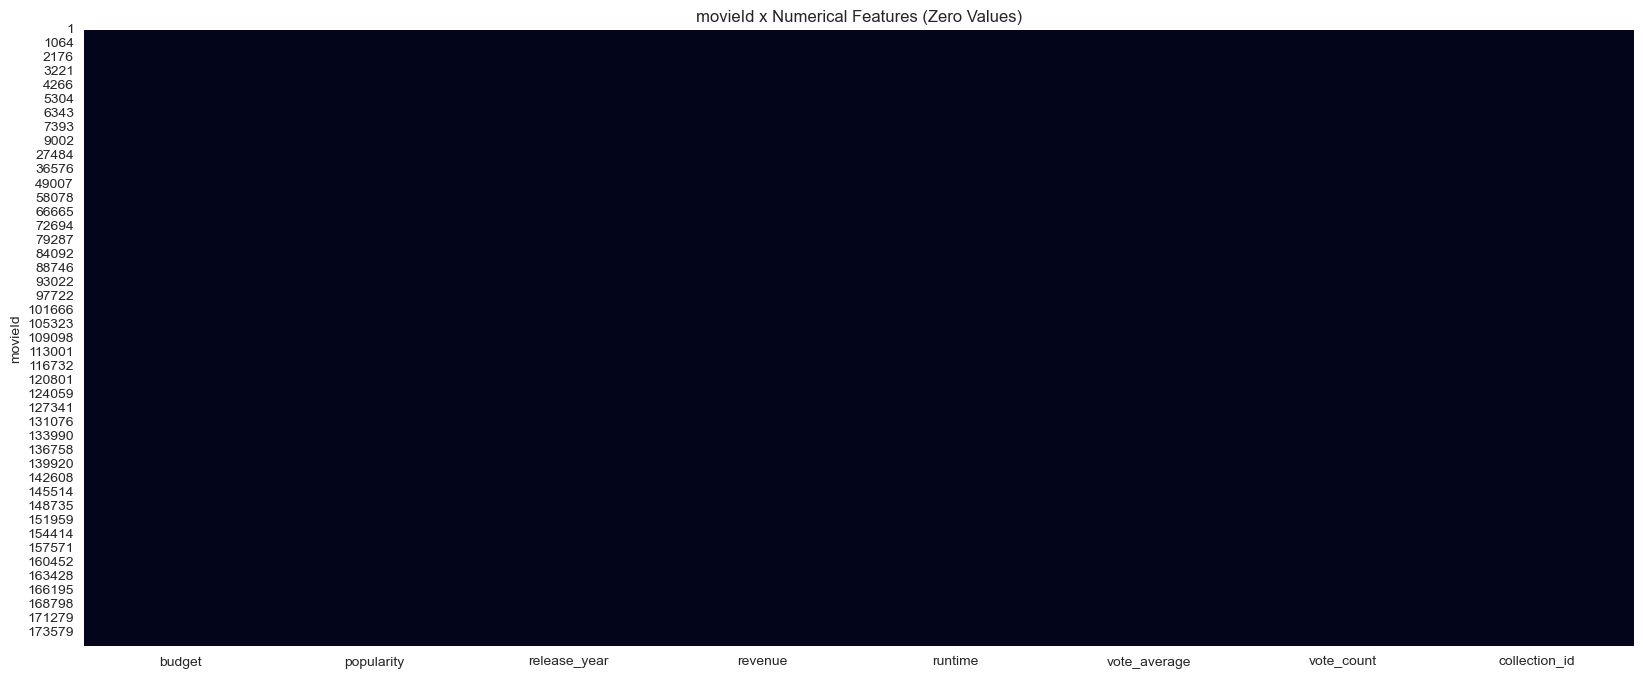

In [41]:
# Create a filtered DataFrame without the 'movieId' column
metadata_filtered = metadata.drop(columns=['movieId', 'genre_id_1', 'genre_id_2', 'genre_id_3',
                                           'genre_id_4', 'genre_id_5', 'genre_id_6', 'genre_id_7', 'genre_id_8'])

# Select only numeric columns from the filtered DataFrame
metadata_numeric = metadata_filtered.select_dtypes(include= [int,float])

# Create a binary DataFrame where 1 indicates a zero value and 0 indicates a non-zero value
binary_metadata = (metadata_numeric == 0)

# Create the heatmap with 'movieId' as y-axis values and showing the color legend
fig, ax = plt.subplots(figsize=(20, 8))
sns.heatmap(binary_metadata.set_index(metadata['movieId']), cbar = False, ax=ax).set_title("movieId x Numerical Features (Zero Values)")
ax.set_ylabel('movieId')
plt.show()

- This is a really wonderful thing to see!
- Will have to make take care of all NaN values again after some more feature engineering!

### Dropping beyond second genre column, and transform them into a label encoded columns
- I have also saved a CSV file of all genres combined into one column to turn into a TFIDF later to compare 
- And a CSV of the Genres in their spread out categorical format
#### Genres and Keywords have been a big question mark for mes as far as the best way to utilize the data, so I want to try a few different methods

##### Start by saving a Genre Ids df and then dropping it for now

In [42]:
genres_ids_list = []
for i in range(1, 9):
    genres_ids_list.append(f'genre_id_{i}')
print(genres_ids_list)

['genre_id_1', 'genre_id_2', 'genre_id_3', 'genre_id_4', 'genre_id_5', 'genre_id_6', 'genre_id_7', 'genre_id_8']


In [43]:
genres_ids_list_to_csv = genres_ids_list.copy()
genres_ids_list_to_csv.append('movieId')

In [44]:
metadata[genres_ids_list_to_csv].to_csv("genres_ids_list_df.csv", index = False)

In [45]:
for i in range(1, 9):
    metadata.drop(columns = f'genre_id_{i}', inplace = True)

##### Saving genres to a categorical Df

In [46]:
genres_cols_list = []
for i in range(1,9):
    genres_cols_list.append(f'genre_name_{i}')
print(genres_cols_list)

['genre_name_1', 'genre_name_2', 'genre_name_3', 'genre_name_4', 'genre_name_5', 'genre_name_6', 'genre_name_7', 'genre_name_8']


In [47]:
genres_cols_list_to_csv = genres_cols_list.copy()
genres_cols_list_to_csv.append('movieId')

In [48]:
metadata[genres_cols_list_to_csv].to_csv("genres_cols_list_df.csv", index = False)

##### Save all genres into a concactenated column to a CSV

In [49]:
metadata['all_genres'] = metadata[genres_cols_list].astype(str).apply('|'.join, axis = 1)

In [50]:
# Splitting the keywords at the delimiter, and removing nan values.
metadata['all_genres'] = metadata['all_genres'].astype(str).apply(lambda x: re.sub('[\|]', ' ', x).strip())
metadata['all_genres'] = metadata['all_genres'].astype(str).apply(lambda x: re.sub('nan', '', x).strip())

In [51]:
metadata[['movieId', 'all_genres']].to_csv("genres_concat_df.csv", index = False)

In [52]:
metadata.drop(columns = 'all_genres', inplace = True)

##### Creating label encoded columns

In [53]:
checkpoint_metadata = metadata.copy()

In [54]:
metadata.drop(columns = genres_cols_list[2:], inplace = True)

In [55]:
genre_cols_list =  genres_cols_list[:2]

In [56]:
counts = metadata[genre_cols_list].apply(pd.Series.value_counts).sum(axis=1)

In [57]:
counts

Action              6023
Adventure           2921
Animation           1736
Comedy             12072
Crime               3110
Documentary         3874
Drama              18241
Family              1633
Fantasy             1468
Foreign              885
History              918
Horror              4015
Music               1227
Mystery             1325
Romance             4041
Science Fiction     1646
TV Movie             546
Thriller            4177
War                  747
Western              754
dtype: int64

In [58]:
metadata[genre_cols_list] = metadata[genre_cols_list].fillna('na')

In [59]:
# Apply label encoding to genres
le = LabelEncoder()
metadata[genre_cols_list] = metadata[genre_cols_list].apply(le.fit_transform)

In [60]:
counts = metadata[genre_cols_list].apply(pd.Series.value_counts).sum(axis=1)
counts

0      6023
1      2921
2      1736
3     12072
4      3110
5      3874
6     18241
7      1633
8      1468
9       885
10      918
11     4015
12     1227
13     1325
14     4041
15     1646
16      546
17     4177
18      747
19      754
20    19407
dtype: int64

### Label Encoding for the rest of the categorical columns

- Start by taking a count of unique values within each different feature

In [61]:
# Print counts for unique values in Studio Ids
print('Production Studio IDs:')
metadata['production_studio_id'].value_counts()

# Print counts for unique values in production_country
print('\nProduction Countries:')
print(metadata['production_country'].value_counts())

# Print counts for unique values in Original languages
print('\Original Languages:')
print(metadata['original_language'].value_counts())

# Print counts for unique values in spoken languages
print('\Spoken Languages:')
print(metadata['spoken_language'].value_counts())

Production Studio IDs:

Production Countries:
US    18410
       6254
GB     3065
FR     2701
CA     1496
      ...  
ML        1
PG        1
TZ        1
MC        1
AZ        1
Name: production_country, Length: 144, dtype: int64
\Original Languages:
en    32209
fr     2436
it     1529
ja     1345
de     1077
      ...  
ay        1
rw        1
cy        1
tg        1
si        1
Name: original_language, Length: 89, dtype: int64
\Spoken Languages:
en    26805
       3810
fr     2424
it     1410
ja     1384
      ...  
tg        1
km        1
fy        1
co        1
ff        1
Name: spoken_language, Length: 117, dtype: int64


- There are a whole lot of "one-off" languages and production countries in this dataset, so I am going to convert anything that doesnt occur at least 100 times into a 'na' value so it gets registered as the same category once encoded.

In [62]:
# Count the unique values in production_studio_id column
prod_studio_counts = metadata['production_studio_id'].value_counts()

# Select production studio IDs that have counts greater than or equal to 100
prod_studio_ids = prod_studio_counts[prod_studio_counts >= 100].index.tolist()

# Filter the dataframe to include only those which fit into that category
metadata['production_studio_id'] = metadata.apply(lambda row: row['production_studio_id'] if row['production_studio_id'] in prod_studio_ids else 0, axis = 1)

In [63]:
# Count the unique values in production_country column
prod_country_counts = metadata['production_country'].value_counts()

# Select production countries that have counts greater than or equal to 100
prod_countries = prod_country_counts[prod_country_counts >= 100].index.tolist()

# Filter the dataframe to include only those which fit into that category
metadata['production_country'] = metadata.apply(lambda row: row['production_country'] if row['production_country'] in prod_countries else 0, axis = 1)

In [64]:
# Count the unique values in original_language column
orig_lang_counts = metadata['original_language'].value_counts()

# Select original languages that have counts greater than or equal to 100
orig_languages = orig_lang_counts[orig_lang_counts >= 100].index.tolist()

# Filter the dataframe to include only those which fit into that category
metadata['original_language'] = metadata.apply(lambda row: row['original_language'] if row['original_language'] in orig_languages else 0, axis = 1)

In [65]:
# Count the unique values in production_studio_id column
counts = metadata['production_studio_id'].value_counts()

# Select counts that are greater than or equal to 100
counts = counts[counts >= 100]

# Print the selected counts
print('Production Studio IDs:')
print(counts)

# Print counts for unique values in production_country
print('\nProduction Countries:')
print(metadata['production_country'].value_counts())

# Print counts for unique values in Original languages
print('\Original Languages:')
print(metadata['original_language'].value_counts())

Production Studio IDs:
0       26405
        11837
4         997
8411      852
306       780
6194      757
33        753
5         429
441       401
6         290
60        272
2         262
12        261
5120      180
14        175
559       163
882       127
9         122
288       109
41        109
9195      102
Name: production_studio_id, dtype: int64

Production Countries:
US    18410
       6254
GB     3065
FR     2701
0      1729
CA     1496
JP     1488
IT     1470
DE     1414
RU      800
IN      779
ES      600
AU      505
HK      466
KR      456
SE      396
FI      324
BE      299
CN      299
DK      297
BR      262
PL      244
MX      235
NL      226
AR      211
CZ      163
AT      151
IE      135
TR      134
GR      131
NO      124
HU      119
Name: production_country, dtype: int64
\Original Languages:
en    32209
fr     2436
it     1529
ja     1345
de     1077
es      992
0       913
ru      825
hi      505
ko      444
zh      409
sv      384
pt      316
cn      313
fi     

##### Encoding these columns into numerical categories!

In [66]:
# Fill NaN values and 0 values in the original_language column with 'na' string
metadata['original_language'] = metadata['original_language'].fillna('na')
metadata['original_language'] = metadata['original_language'].replace(0, 'na')
                                                                                          
# Instantiate a LabelEncoder object
le = LabelEncoder()

# Fit and transform the original_language column using label encoding
metadata['original_language_encoded'] = le.fit_transform(metadata['original_language'])

# Print the encoded values
metadata['original_language_encoded'].value_counts()

5     32209
9      2436
12     1529
13     1345
3      1077
6       992
15      913
20      825
10      505
14      444
23      409
21      384
19      316
0       313
8       296
16      248
2       225
18      217
22      150
1       130
4       113
17      106
7       101
11      100
Name: original_language_encoded, dtype: int64

In [67]:
# Fill NaN values and 0 values in the original_language column with 'na' string
metadata['production_country'] = metadata['production_country'].fillna('na')
metadata['production_country'] = metadata['production_country'].replace(0, 'na')
                                                                                          
# Instantiate a LabelEncoder object
le = LabelEncoder()

# Fit and transform the original_language column using label encoding
metadata['production_country_encoded'] = le.fit_transform(metadata['production_country'])

# Print the encoded values
metadata['production_country_encoded'].value_counts()

30    18410
0      6254
14     3065
13     2701
31     1729
6      1496
21     1488
20     1470
9      1414
27      800
19      779
11      600
3       505
16      466
22      456
28      396
12      324
4       299
7       299
10      297
5       262
26      244
23      235
24      226
1       211
8       163
2       151
18      135
29      134
15      131
25      124
17      119
Name: production_country_encoded, dtype: int64

In [68]:
# Fill NaN values and 0 values in the original_language column with 'na' string
metadata['production_studio_id'] = metadata['production_studio_id'].fillna(1)
metadata['production_studio_id'] = metadata['production_studio_id'].replace("", 1)
                                                                                          
# Instantiate a LabelEncoder object
le = LabelEncoder()

# Fit and transform the original_language column using label encoding
metadata['production_studio_id_encoded'] = le.fit_transform(metadata['production_studio_id'])

# Print the encoded values
metadata['production_studio_id_encoded'].value_counts()

0     26405
1     11837
3       997
19      852
13      780
18      757
9       753
4       429
14      401
5       290
11      272
2       262
7       261
17      180
8       175
15      163
16      127
6       122
12      109
10      109
20      102
Name: production_studio_id_encoded, dtype: int64

In [69]:
cols_to_drop = ['production_studio_id', 'production_country', 'original_language', 'spoken_language']
metadata.drop(columns = cols_to_drop, inplace = True)

### Lets check our progress.

In [70]:
metadata.describe()

,budget,movieId,popularity,release_year,revenue,runtime,vote_average,vote_count,genre_name_1,genre_name_2,collection_id,original_language_encoded,production_country_encoded,production_studio_id_encoded
count,4.54e+04,4.54e+04,4.54e+04,4.54e+04,4.54e+04,4.51e+04,4.54e+04,4.54e+04,4.54e+04,4.54e+04,4.49e+03,4.54e+04,4.54e+04,4.54e+04
mean,7.48e+06,9.67e+04,2.93,1.99e+03,2.04e+07,97.3,6.01,1.11e+02,6.73,12.6,1.84e+05,6.86,19.5,1.98
std,1.69e+07,5.73e+04,6.01,24.0,6.32e+07,34.1,1.22,4.92e+02,5.51,7.11,1.42e+05,4.23,11.4,4.53
min,1.0,1.0,1e-06,1.87e+03,0.128,1.0,0.5,1.0,0.0,0.0,10.0,0.0,0.0,0.0
25%,7.47e+05,4.9e+04,0.391,1.98e+03,3.32e+06,87.0,5.4,4.0,3.0,6.0,8.6e+04,5.0,10.0,0.0
50%,5.29e+06,1.09e+05,1.13,2e+03,1.41e+07,95.0,6.0,10.0,6.0,14.0,1.42e+05,5.0,22.0,0.0
75%,6.7e+06,1.45e+05,3.69,2.01e+03,1.52e+07,1.07e+02,6.8,34.0,8.0,20.0,2.94e+05,5.0,30.0,1.0
max,3.8e+08,1.76e+05,5.47e+02,2.02e+03,2.79e+09,1.26e+03,10.0,1.41e+04,20.0,20.0,4.8e+05,23.0,31.0,20.0


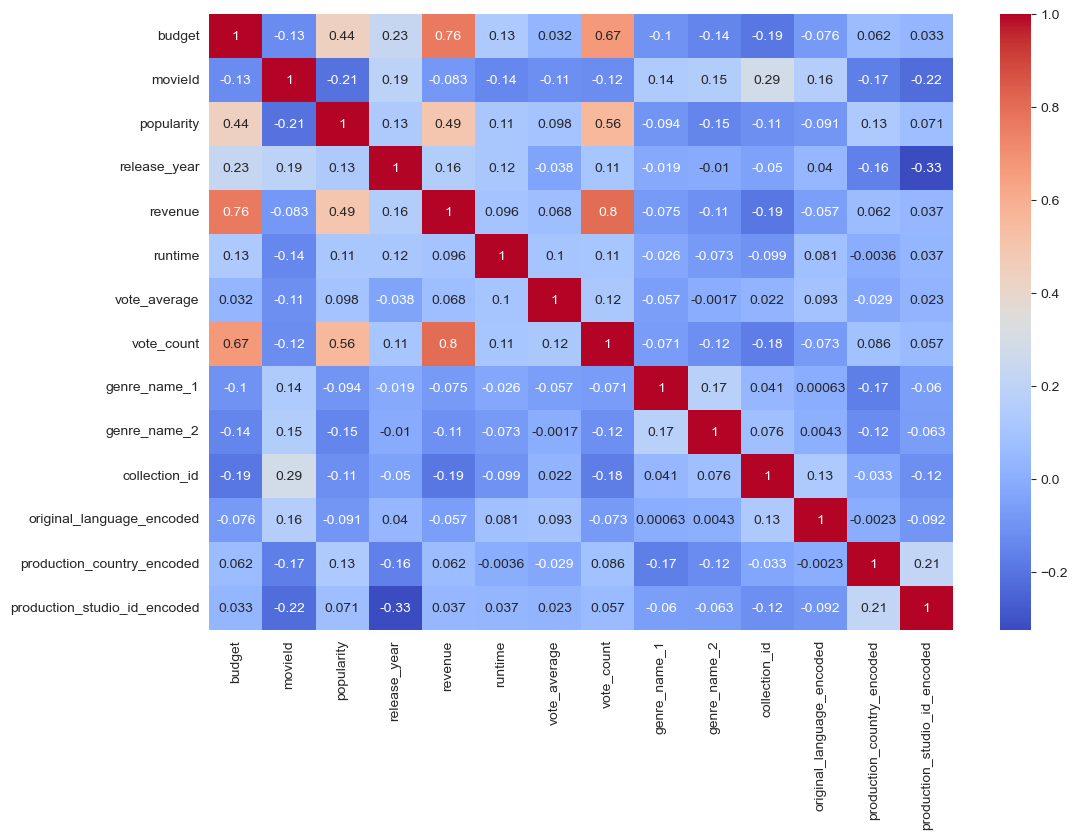

In [71]:
# Set the figure size
plt.figure(figsize=(12, 8))

# Select only the numeric columns of metadata
numeric_cols = metadata.select_dtypes(include=np.number)

# Create a heatmap of the correlations between the numeric columns
sns.heatmap(numeric_cols.corr(), cmap='coolwarm', annot=True)

# Show the plot
plt.show()

In [72]:
metadata.to_csv("metadata_checkpoint.csv", index = False)

### Keywords Dataframe Expantion and Preprocessing

#### Run function made on earlier project expiriments made to extract nested data from the keywords columns

In [73]:
def retrieve_first_10_keywords(df):
    '''Function to retrieve the first 10 keywords for each movie in the Keywords file'''
    
    # Creating column names to account for the amount of sub-categories within each entry
    col_names = [f'keyword_id_{i}' for i in range(1, 11)]
    col_names += [f'keyword_name_{i}' for i in range(1, 11)]
    
    # Creating a list of dictionaries to store the keyword data
    keyword_list = []
    
    # Iterating through the dataframe with the iterrows method (its kinda like enumerate for DF's), 
    # using tqdm as a timer. Index from the "enumeration" is helpful for multi-indexing later.
    for index, row in tqdm(df.iterrows(), desc='keywords'):
        
        # Using ast library to evaluate a string formatted as a dictionary, which basically typecasts. 
        ## ast library works better than python's eval method IMO.
        keyword_data = ast.literal_eval(row[1])
        
        # Using enumerate here to be able to perform efficient multi-indexing.
        keywords_dict = {}
        for counter, dictionary in enumerate(keyword_data[:10], start=1):
            
            # Adding the "id" and "name" keys to a dictionary for each keyword
            keywords_dict[f'keyword_id_{counter}'] = dictionary.get('id')
            keywords_dict[f'keyword_name_{counter}'] = dictionary.get('name')
            
        # Appending the dictionary to the keyword list
        keyword_list.append(keywords_dict)
    
    # Creating a new dataframe from the keyword list
    keyword_df = pd.DataFrame(keyword_list, columns=col_names)
    
    # Concatenating the original dataframe with the keyword dataframe
    df = pd.concat([df['id'], keyword_df], axis=1)
    
    df.rename(columns = {'id': 'movieId'}, inplace = True)
    # Returning the expanded dataframe
    return df


In [74]:
keywords = pd.read_csv("movies_keywords.csv")
keywords = retrieve_first_10_keywords(keywords)

keywords: 0it [00:00, ?it/s]

##### We are going to give keywords the same treatment as genres to explore the way to incorporate this data that adds the most predictability to the label

##### Saving Keyword Ids to a dataframe

In [75]:
keywords_ids_list = []
for i in range(1, 11):
    keywords_ids_list.append(f'keyword_id_{i}')
print(keywords_ids_list)

['keyword_id_1', 'keyword_id_2', 'keyword_id_3', 'keyword_id_4', 'keyword_id_5', 'keyword_id_6', 'keyword_id_7', 'keyword_id_8', 'keyword_id_9', 'keyword_id_10']


In [76]:
keywords_ids_list_to_csv = keywords_ids_list.copy()
keywords_ids_list_to_csv.append('movieId')

In [77]:
keywords[keywords_ids_list_to_csv].to_csv("keywords_ids_list_df.csv", index = False)

##### Saving keywords to a categorical Df

In [78]:
keywords_cols_list = []
for i in range(1, 11):
    keywords_cols_list.append(f'keyword_name_{i}')
print(keywords_cols_list)

['keyword_name_1', 'keyword_name_2', 'keyword_name_3', 'keyword_name_4', 'keyword_name_5', 'keyword_name_6', 'keyword_name_7', 'keyword_name_8', 'keyword_name_9', 'keyword_name_10']


In [79]:
keyword_cols_to_csv = keywords_cols_list.copy()
keyword_cols_to_csv.append('movieId')

In [80]:
keywords[keyword_cols_to_csv].to_csv("keywords_cols_list_df.csv", index = False)

##### Save all keywords into a concactenated column to a CSV

In [81]:
keywords['all_keywords'] = keywords[keywords_cols_list].astype(str).apply('|'.join, axis = 1)

In [82]:
keywords.drop(columns = keywords_cols_list, axis = 0, inplace = True)

In [83]:
# Splitting the keywords at the delimiter, and removing nan values.
keywords['all_keywords'] = keywords['all_keywords'].astype(str).apply(lambda x: re.sub('[\|]', ' ', x).strip())
keywords['all_keywords'] = keywords['all_keywords'].astype(str).apply(lambda x: re.sub('nan', '', x).strip())

In [84]:
keywords.columns

Index(['movieId', 'keyword_id_1', 'keyword_id_2', 'keyword_id_3',
       'keyword_id_4', 'keyword_id_5', 'keyword_id_6', 'keyword_id_7',
       'keyword_id_8', 'keyword_id_9', 'keyword_id_10', 'all_keywords'],
      dtype='object')

In [85]:
keywords[['movieId', 'all_keywords']].to_csv("keywords_concat_df.csv", index = False)

##### Since there are so many unique values for keywords, label encoding won't be an option. instead, I'll append the first 3 keyword id columns to the product df, then to the user df

In [86]:
keywords

,movieId,keyword_id_1,keyword_id_2,keyword_id_3,keyword_id_4,keyword_id_5,keyword_id_6,keyword_id_7,keyword_id_8,keyword_id_9,keyword_id_10,all_keywords
0,1,9.31e+02,4.29e+03,5.2e+03,6.05e+03,9.71e+03,9.82e+03,1.66e+05,1.71e+05,1.87e+05,NaN,jealousy toy boy friendship friends rivalry bo...
1,2,1.01e+04,1.09e+04,1.51e+04,3.35e+04,1.58e+05,1.58e+05,NaN,NaN,NaN,NaN,board game disappearance based on children's b...
2,3,1.5e+03,1.24e+04,1.79e+05,2.09e+05,NaN,NaN,NaN,NaN,NaN,NaN,fishing best friend duringcreditsstinger old men
3,4,8.18e+02,1.01e+04,1.48e+04,1.52e+04,3.35e+04,NaN,NaN,NaN,NaN,NaN,based on novel interracial relationship single...
4,5,1.01e+03,1.6e+03,2.25e+03,5e+03,5.6e+03,1.07e+04,1.31e+04,3.34e+04,1.71e+05,NaN,baby midlife crisis confidence aging daughter ...
...,...,...,...,...,...,...,...,...,...,...,...,...
46333,176269,1.07e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tragic love
46334,176271,2.68e+03,1.45e+04,2.15e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,artist play pinoy
46335,176273,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
46336,176275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,


### Combining together Product and User data

#### Assembling Product DF

In [87]:
metadata = pd.read_csv("metadata_checkpoint.csv")

In [88]:
metadata.columns

Index(['budget', 'movieId', 'original_title', 'overview', 'popularity',
       'release_year', 'revenue', 'runtime', 'status', 'tagline', 'title',
       'vote_average', 'vote_count', 'genre_name_1', 'genre_name_2',
       'collection_id', 'part_of_collection', 'original_language_encoded',
       'production_country_encoded', 'production_studio_id_encoded'],
      dtype='object')

##### Using genre ids instead of genre names

In [89]:
metadata.drop(columns = ['genre_name_1', 'genre_name_2'], inplace = True)

In [90]:
genre_ids = pd.read_csv("genres_ids_list_df.csv")

In [91]:
genre_id_list = []
for i in range(1, 9):
    genre_id_list.append(f'genre_id_{i}')
print(genre_id_list)

['genre_id_1', 'genre_id_2', 'genre_id_3', 'genre_id_4', 'genre_id_5', 'genre_id_6', 'genre_id_7', 'genre_id_8']


In [92]:
genre_ids.drop(columns = genre_id_list[3:], inplace = True)

In [93]:
genre_ids = genre_ids.fillna(0)
genre_ids = genre_ids.astype(int)
genre_ids.head(1)

,genre_id_1,genre_id_2,genre_id_3,movieId
0,16,35,10751,1


In [94]:
metadata = pd.merge(genre_ids, metadata, on = "movieId")

##### Adding in keyword Id's

In [95]:
keywords_ids = pd.read_csv("keywords_ids_list_df.csv")

In [96]:
keywords_id_list = []
for i in range(1, 11):
    keywords_id_list.append(f'keyword_id_{i}')
print(keywords_id_list)

['keyword_id_1', 'keyword_id_2', 'keyword_id_3', 'keyword_id_4', 'keyword_id_5', 'keyword_id_6', 'keyword_id_7', 'keyword_id_8', 'keyword_id_9', 'keyword_id_10']


In [97]:
keywords_ids.drop(columns = keywords_id_list[3:], inplace = True)

In [98]:
keywords_ids = keywords_ids.fillna(0)
keywords_ids = keywords_ids.astype(int)
keywords_ids.head(1)

,keyword_id_1,keyword_id_2,keyword_id_3,movieId
0,931,4290,5202,1


In [99]:
product_df = pd.merge(keywords_ids, metadata, on = "movieId")

In [100]:
product_df.columns

Index(['keyword_id_1', 'keyword_id_2', 'keyword_id_3', 'movieId', 'genre_id_1',
       'genre_id_2', 'genre_id_3', 'budget', 'original_title', 'overview',
       'popularity', 'release_year', 'revenue', 'runtime', 'status', 'tagline',
       'title', 'vote_average', 'vote_count', 'collection_id',
       'part_of_collection', 'original_language_encoded',
       'production_country_encoded', 'production_studio_id_encoded'],
      dtype='object')

#### Combining our product df and our 2 user dfs

In [324]:
user_train_df = pd.read_csv("train.csv")
print("Shape of train: ")
print(f'{user_train_df.shape} \n')

user_test_df = pd.read_csv("test.csv")
print("Shape of test: ")
print(f'{user_test_df.shape} \n')

Shape of train: 
(70002, 2) 

Shape of test: 
(30002, 1) 



In [325]:
user_train_df.head()

,userId_movieId,rating
0,10_1358,0.4
1,237_1544,0.7
2,54_373,1.0
3,11_2053,0.8
4,183_2524,0.6


In [326]:
user_test_df.head()

,userId_movieId
0,469_2124
1,439_3753
2,522_1682
3,429_1217
4,71_1210


In [327]:
cols = ['userId','movieId']
user_train_df[cols] = user_train_df['userId_movieId'].str.split('_',expand=True)
user_train_df[cols] = user_train_df[cols].astype(int)
                                          
user_test_df[cols] = user_test_df['userId_movieId'].str.split('_',expand=True)
user_test_df[cols] = user_test_df[cols].astype(int)


In [328]:
user_train_df = user_train_df.drop(columns = 'userId_movieId', axis = 0)
user_train_df.head()

,rating,userId,movieId
0,0.4,10,1358
1,0.7,237,1544
2,1.0,54,373
3,0.8,11,2053
4,0.6,183,2524


In [329]:
user_test_df = user_test_df.drop(columns = 'userId_movieId', axis = 0)
user_test_df.head()

,userId,movieId
0,469,2124
1,439,3753
2,522,1682
3,429,1217
4,71,1210


In [330]:
train_df = user_train_df.merge(product_df, on = 'movieId', how = 'left')
sub = ['userId', 'movieId']
user_train_df = user_train_df.drop_duplicates(subset = sub)
print(user_train_df.shape)
user_train_df.head()

(70002, 3)


,rating,userId,movieId
0,0.4,10,1358
1,0.7,237,1544
2,1.0,54,373
3,0.8,11,2053
4,0.6,183,2524


In [331]:
test_df = user_test_df.merge(product_df, on = 'movieId', how = 'left')
sub = ['userId', 'movieId']
user_test_df = user_test_df.drop_duplicates(subset = sub)
print(user_test_df.shape)
user_test_df.head()

(30002, 2)


,userId,movieId
0,469,2124
1,439,3753
2,522,1682
3,429,1217
4,71,1210


#### Checking general distribution of Label


 mu = 0.71 and sigma = 0.21



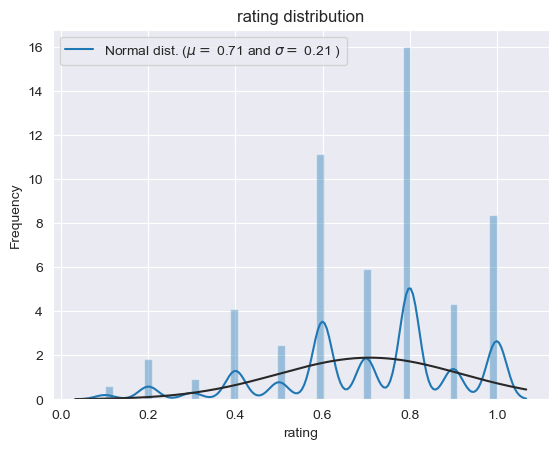

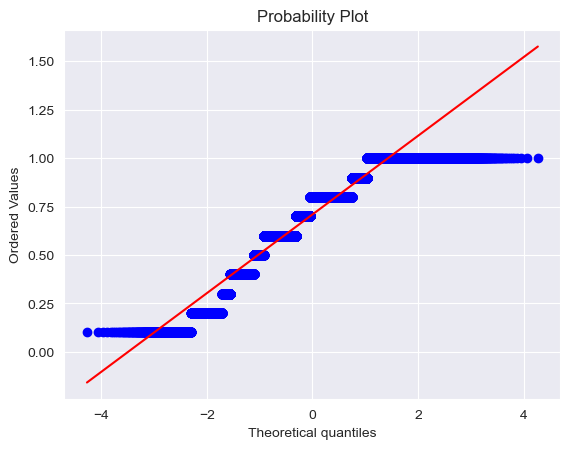

In [332]:
sns.distplot(train_df['rating'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train_df['rating'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('rating distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train_df['rating'], plot=plt)
plt.show()

- I was thinking about applying some kind of log transformation on the label, but I'll hold off for now since there are only 10 continuous values that are being used.

### I want to take some time here to compare the singular value decomposition of TFIDF matricies vs just using the keyword or genre id's

#### Import dependencies and set up preprocessing tasks as a function

In [333]:
import nltk
import string
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [334]:
stemmer = PorterStemmer()

# Define a function to remove punctuation and stem words
def preprocess_text(text):
    # Remove punctuation
    no_punct = "".join([char for char in text if char not in string.punctuation])
    # Tokenize the text into words
    tokens = nltk.word_tokenize(no_punct)
    # Stem each word in the tokens list using the PorterStemmer object
    stemmed = [stemmer.stem(word) for word in tokens]
    # Join the stemmed words back into a single string
    result = " ".join(stemmed)
    return result

#### Process Keywords

In [335]:
keywords_concat = pd.read_csv("keywords_concat_df.csv")
keywords_concat['all_keywords'] = keywords_concat['all_keywords'].fillna("").astype(str)
keywords_concat['all_keywords'] = keywords_concat['all_keywords'].apply(preprocess_text)

In [336]:
vectorizer = TfidfVectorizer()
vectorizer.fit(keywords_concat['all_keywords'])
tfidf_matrix_keywords = vectorizer.transform(keywords_concat['all_keywords'])

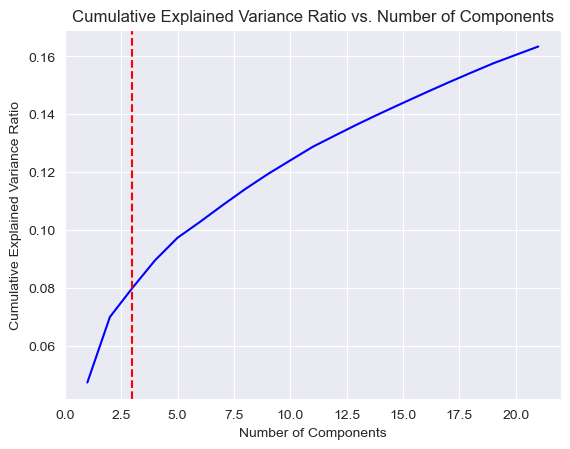

In [337]:
# Fit the TruncatedSVD model
svd_model = TruncatedSVD(n_components = 21)
svd_model.fit(tfidf_matrix_keywords)

# Calculate the explained variance ratio for each component
variance_ratio = svd_model.explained_variance_ratio_

# Calculate the cumulative sum of the explained variance ratio
cumulative_variance_ratio = np.cumsum(variance_ratio)

# Plot the cumulative explained variance ratio
plt.plot(range(1, len(cumulative_variance_ratio)+1), cumulative_variance_ratio, 'b-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs. Number of Components')


# Find the elbow point, if it exists
elbow_point = np.where(np.diff(cumulative_variance_ratio) < 0.01)[0]
if len(elbow_point) > 0:
    elbow_point = elbow_point[0] + 1
    # Add a vertical line at the elbow point
    plt.axvline(x=elbow_point, linestyle='--', color='r')

# Show the plot
plt.show()

In [338]:
svd_model = TruncatedSVD(n_components = 3)
svd_matrix_keywords = svd_model.fit_transform(tfidf_matrix_keywords)

In [339]:
keywords_concat = pd.merge(keywords_concat, pd.DataFrame(svd_matrix_keywords), left_index = True, right_index = True)
keywords_concat.drop(columns = 'all_keywords', inplace = True)

In [340]:
for i in range (0, 4):
    keywords_concat.rename(columns = {i: f'truncd_keyword_{i}'}, inplace = True)

In [341]:
keywords_concat.head(2)

,movieId,truncd_keyword_0,truncd_keyword_1,truncd_keyword_2
0,1,0.00271,0.00576,0.0113
1,2,0.00428,0.0106,0.0367


#### Process Genres

In [342]:
genres_concat = pd.read_csv("genres_concat_df.csv")
genres_concat['all_genres'] = genres_concat['all_genres'].fillna("").astype(str)
genres_concat['all_genres'] = genres_concat['all_genres'].apply(preprocess_text)

In [343]:
vectorizer = TfidfVectorizer()
vectorizer.fit(genres_concat['all_genres'])
tfidf_matrix_genres = vectorizer.transform(genres_concat['all_genres'])

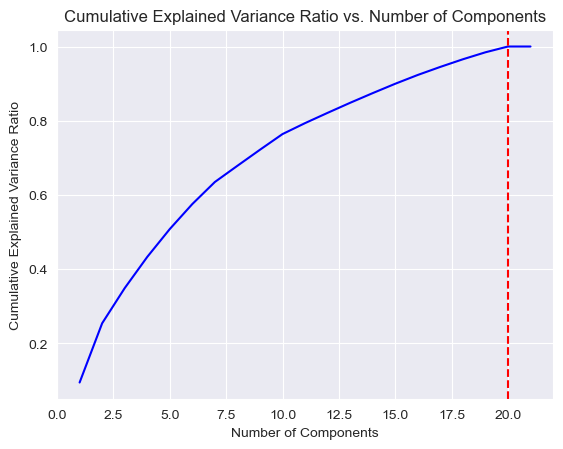

In [344]:
# Fit the TruncatedSVD model
svd_model = TruncatedSVD(n_components = 21)
svd_model.fit(tfidf_matrix_genres)

# Calculate the explained variance ratio for each component
variance_ratio = svd_model.explained_variance_ratio_

# Calculate the cumulative sum of the explained variance ratio
cumulative_variance_ratio = np.cumsum(variance_ratio)

# Plot the cumulative explained variance ratio
plt.plot(range(1, len(cumulative_variance_ratio)+1), cumulative_variance_ratio, 'b-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs. Number of Components')


# Find the elbow point, if it exists
elbow_point = np.where(np.diff(cumulative_variance_ratio) < 0.01)[0]
if len(elbow_point) > 0:
    elbow_point = elbow_point[0] + 1
    # Add a vertical line at the elbow point
    plt.axvline(x=elbow_point, linestyle='--', color='r')

# Show the plot
plt.show()

In [345]:
svd_model = TruncatedSVD(n_components = 20)
svd_matrix_keywords = svd_model.fit_transform(tfidf_matrix_genres)

In [346]:
genres_concat = pd.merge(genres_concat, pd.DataFrame(svd_matrix_keywords), left_index = True, right_index = True)
genres_concat.drop(columns = 'all_genres', inplace = True)

In [347]:
for i in range (0, 21):
    genres_concat.rename(columns = {i: f'truncd_genre_{i}'}, inplace = True)

In [348]:
genres_concat.head(2)

,movieId,truncd_genre_0,truncd_genre_1,truncd_genre_2,truncd_genre_3,truncd_genre_4,truncd_genre_5,truncd_genre_6,truncd_genre_7,truncd_genre_8,...,truncd_genre_10,truncd_genre_11,truncd_genre_12,truncd_genre_13,truncd_genre_14,truncd_genre_15,truncd_genre_16,truncd_genre_17,truncd_genre_18,truncd_genre_19
0,1,0.221,0.348,0.0274,0.00614,-0.0965,-0.0706,0.245,0.148,0.186,...,-0.349,0.179,-0.134,-0.16,0.129,-0.154,0.231,0.0248,-0.00422,-0.0169
1,2,0.0746,0.0382,0.116,0.0102,0.0169,-0.177,0.441,0.128,0.0916,...,0.183,-0.201,0.0177,0.138,-0.136,0.285,-0.289,-0.0154,0.0131,-0.0472


#### Combine genres and keywords and copy Train DF to compare the two approaches

In [349]:
genres_keywords = pd.merge(genres_concat, keywords_concat, on = 'movieId')

In [350]:
genres_keywords.head(2)

,movieId,truncd_genre_0,truncd_genre_1,truncd_genre_2,truncd_genre_3,truncd_genre_4,truncd_genre_5,truncd_genre_6,truncd_genre_7,truncd_genre_8,...,truncd_genre_13,truncd_genre_14,truncd_genre_15,truncd_genre_16,truncd_genre_17,truncd_genre_18,truncd_genre_19,truncd_keyword_0,truncd_keyword_1,truncd_keyword_2
0,1,0.221,0.348,0.0274,0.00614,-0.0965,-0.0706,0.245,0.148,0.186,...,-0.16,0.129,-0.154,0.231,0.0248,-0.00422,-0.0169,0.00271,0.00576,0.0113
1,2,0.0746,0.0382,0.116,0.0102,0.0169,-0.177,0.441,0.128,0.0916,...,0.138,-0.136,0.285,-0.289,-0.0154,0.0131,-0.0472,0.00428,0.0106,0.0367


In [351]:
gk_list = ['rating', 'movieId', 'genre_id_1', 'genre_id_2', 'genre_id_3', 'keyword_id_1', 'keyword_id_2', 'keyword_id_3']
temp_train = train_df[gk_list].copy()

In [352]:
temp_train =  pd.merge(temp_train, genres_keywords, on = 'movieId')

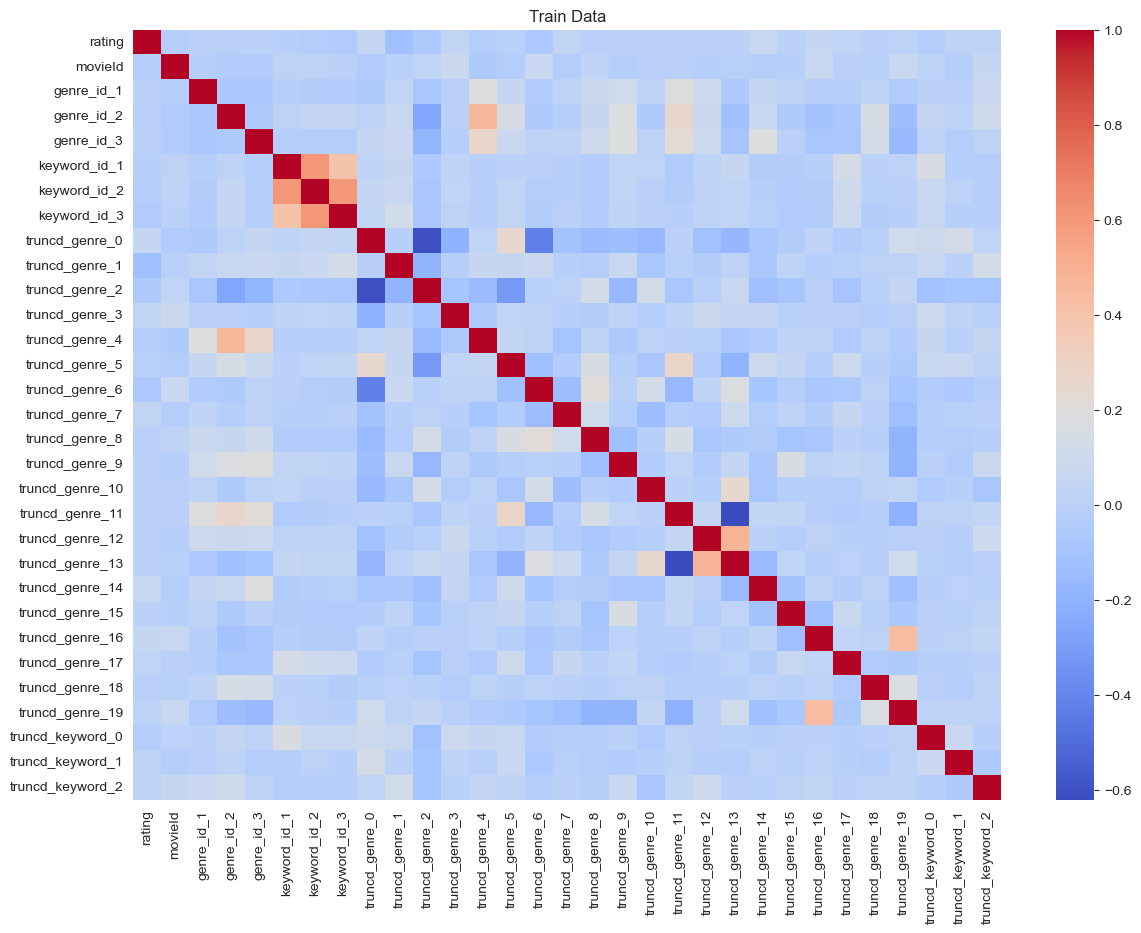

In [353]:
# Set the figure size
plt.figure(figsize=(14, 10))

# Create a heatmap of the correlations
sns.heatmap(temp_train.corr(), cmap = 'coolwarm', annot = False)

# Set title
plt.title('Train Data')

# Show the plot
plt.show()

### Lets check how features affect the label, and further preprocess the data!

In [354]:
train_df =  pd.merge(train_df, genres_keywords, on = 'movieId', how = 'left')
test_df =  pd.merge(test_df, genres_keywords, on = 'movieId', how = 'left')
sub = ['userId', 'movieId']
train_df = train_df.drop_duplicates(subset = sub)
test_df = test_df.drop_duplicates(subset = sub)

In [355]:
train_df.shape

(70002, 49)

In [356]:
test_df.shape

(30002, 48)

In [357]:
to_drop = ['overview', 'tagline', 'title', 'collection_id', 'part_of_collection', 'original_title', 'status',
           'genre_id_1', 'genre_id_2', 'genre_id_3', 'keyword_id_1', 'keyword_id_2', 'keyword_id_3']

In [358]:
train_df.drop(columns = to_drop, inplace = True)
test_df.drop(columns = to_drop, inplace = True)

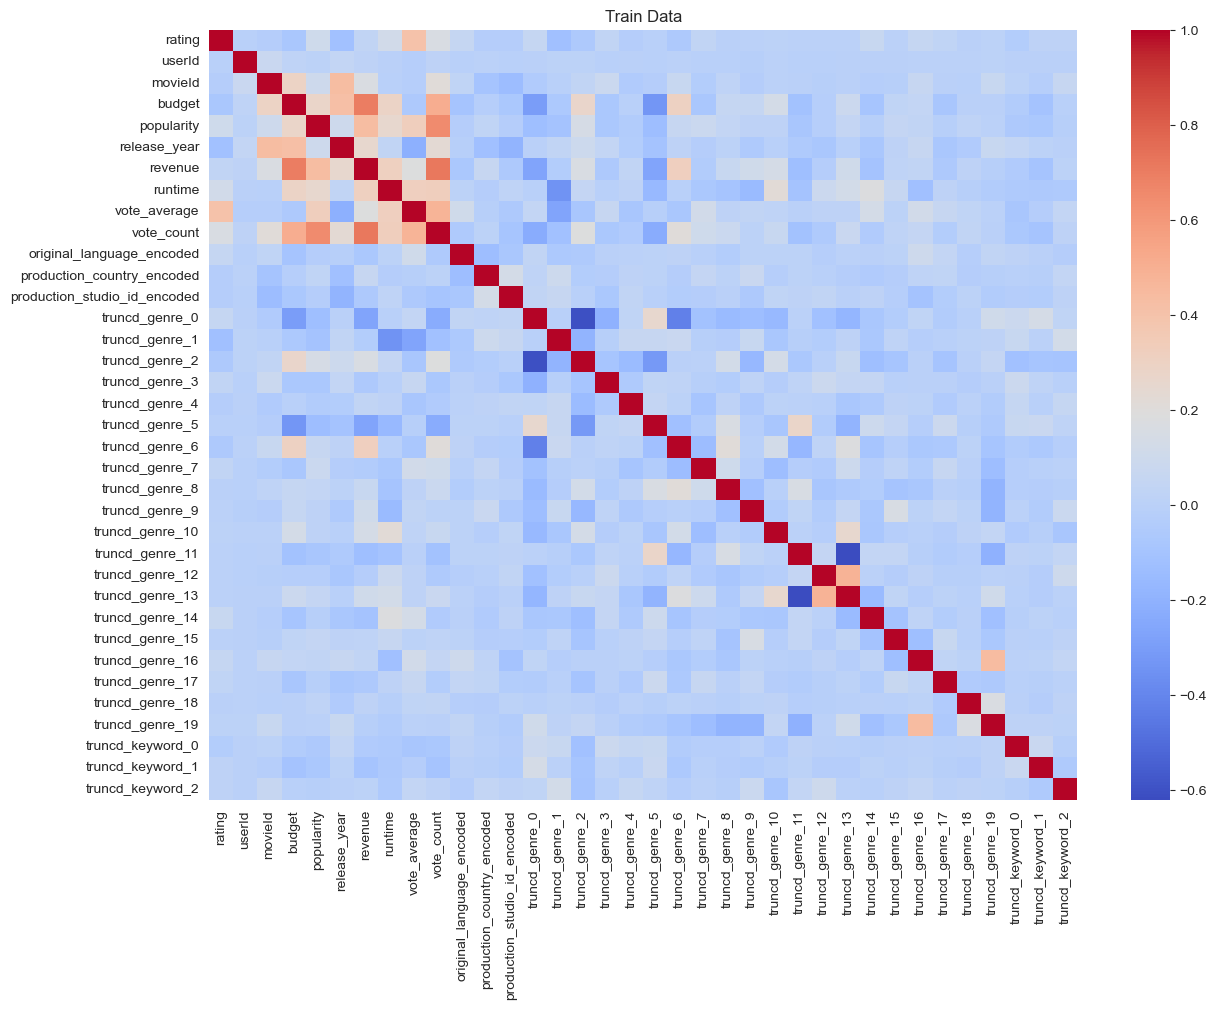

In [359]:
# Set the figure size
plt.figure(figsize=(14, 10))

# Create a heatmap of the correlations between the numeric columns
sns.heatmap(train_df.corr(), cmap = 'coolwarm', annot = False)

# Set title
plt.title('Train Data')

# Show the plot
plt.show()

#### Our correlation matrix isn't showing any linear relationships that are too crazy, but I've got a good feeling about this regardless.

#### Handling outliers for all of the numerical columns.

In [360]:
def remove_outliers(df, cols):
    '''Remove outliers from numerical columns using the interquartile range method.'''
    
    new_df = df.copy()
    
    for col in tqdm(cols, desc = 'Handling Outliers'):
        if new_df[col].dtype != 'int64' and new_df[col].dtype != 'float64':
            continue
            
        Q1 = new_df[col].quantile(0.25)
        Q3 = new_df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        new_df[col] = new_df[col].clip(lower=lower_bound, upper=upper_bound)
        
    return new_df


In [361]:
cols = ['budget', 'popularity', 'release_year', 'runtime', 'vote_average', 'revenue', 'vote_count']

train_df = remove_outliers(train_df, cols)
test_df = remove_outliers(test_df, cols)

Handling Outliers:   0%|          | 0/7 [00:00<?, ?it/s]

Handling Outliers:   0%|          | 0/7 [00:00<?, ?it/s]

### Imputing the rest of the NA values

In [362]:
for col in train_df.drop(columns = ['rating', 'movieId', 'userId']).columns:
    train_df[col] = train_df[col].fillna(train_df[col].median())
    train_df[col] = train_df[col].replace(0, train_df[col].mean())

In [363]:
for col in test_df.drop(columns = ['movieId', 'userId']).columns:
    test_df[col] = test_df[col].fillna(test_df[col].median())
    test_df[col] = test_df[col].replace(0, test_df[col].mean())

In [364]:
# Train
total = train_df.isnull().sum().sort_values(ascending = True)
percent = (train_df.isnull().sum() / train_df.isnull().count()).sort_values(ascending = True)
missing_data = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
missing_data

,Total,Percent
rating,0,0.0
truncd_genre_7,0,0.0
truncd_genre_8,0,0.0
truncd_genre_9,0,0.0
truncd_genre_10,0,0.0
truncd_genre_11,0,0.0
truncd_genre_12,0,0.0
truncd_genre_6,0,0.0
truncd_genre_13,0,0.0
truncd_genre_15,0,0.0


In [365]:
# Test
total = test_df.isnull().sum().sort_values(ascending = True)
percent = (test_df.isnull().sum() / test_df.isnull().count()).sort_values(ascending = True)
missing_data = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
missing_data

,Total,Percent
userId,0,0.0
truncd_genre_7,0,0.0
truncd_genre_8,0,0.0
truncd_genre_9,0,0.0
truncd_genre_10,0,0.0
truncd_genre_11,0,0.0
truncd_genre_12,0,0.0
truncd_genre_6,0,0.0
truncd_genre_13,0,0.0
truncd_genre_15,0,0.0


- Sweet, we are getting close to our modelling stage!

### Checking for skew in the data

#### Train Set

In [366]:
ignore = ['rating', 'movieId', 'userId']
numeric_feats = train_df.drop(columns = ignore).dtypes[train_df.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = train_df[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
truncd_genre_19,19.8
truncd_keyword_0,9.92
truncd_keyword_2,9.4
truncd_genre_3,8.35
truncd_keyword_1,8.3
truncd_genre_17,6.93
original_language_encoded,6.85
truncd_genre_12,4.21
truncd_genre_14,3.11
truncd_genre_15,1.83


In [367]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    train_df[feat] += 1
    train_df[feat] = boxcox1p(train_df[feat], lam)
    
train_df[skewed_features] = np.log1p(train_df[skewed_features])

There are 33 skewed numerical features to Box Cox transform


In [368]:
ignore = ['rating', 'movieId', 'userId']
numeric_feats = train_df.drop(columns = ignore).dtypes[train_df.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = train_df[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
truncd_genre_19,13.1
truncd_keyword_0,8.24
truncd_genre_3,8.04
truncd_keyword_2,7.47
truncd_keyword_1,6.9
truncd_genre_17,6.11
original_language_encoded,4.87
truncd_genre_12,3.69
truncd_genre_14,2.51
truncd_genre_15,1.3


#### Test Set

In [369]:
ignore = ['movieId', 'userId']
numeric_feats = test_df.drop(columns = ignore).dtypes[test_df.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = test_df[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
truncd_genre_19,19.6
truncd_keyword_0,9.81
truncd_keyword_2,9.26
truncd_keyword_1,8.56
truncd_genre_3,8.19
original_language_encoded,7.06
truncd_genre_17,6.83
truncd_genre_12,4.24
truncd_genre_14,3.17
truncd_genre_15,1.84


In [370]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    test_df[feat] += 1
    test_df[feat] = boxcox1p(test_df[feat], lam)
    
test_df[skewed_features] = np.log1p(test_df[skewed_features])

There are 33 skewed numerical features to Box Cox transform


In [371]:
ignore = ['movieId', 'userId']
numeric_feats = test_df.drop(columns = ignore).dtypes[test_df.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = test_df[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
truncd_genre_19,13.1
truncd_keyword_0,8.21
truncd_genre_3,7.9
truncd_keyword_2,7.29
truncd_keyword_1,7.15
truncd_genre_17,6.03
original_language_encoded,5.04
truncd_genre_12,3.73
truncd_genre_14,2.56
truncd_genre_15,1.32


In [372]:
train_df.to_csv("train_checkpoint.csv", index = False)
test_df.to_csv("test_checkpoint.csv", index = False)

# Modelling:

### For now, lets get a performance baseline from the various models we will be using.

In [2]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
from sklearn.feature_selection import RFE

In [36]:
train = pd.read_csv("train_checkpoint.csv")
test = pd.read_csv("test_checkpoint.csv")

In [37]:
X_train = train.drop(columns = 'rating')
y_train = train['rating']

X_test = test

#### Set up cross val Function

In [5]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle = True, random_state = 42).get_n_splits(X_train.values)
    rmse = np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring = "neg_mean_squared_error", cv = kf))
    return(rmse)

#### LASSO

In [6]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha = 0.0005, random_state = 42))


In [7]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1925 (0.0008)



In [8]:
score

array([0.1926777 , 0.19300907, 0.19121786, 0.19343816, 0.19198441])

#### ENET

In [9]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))


In [10]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1925 (0.0008)



#### KRR

In [11]:
# KRR = KernelRidge()


In [12]:
# score = rmsle_cv(KRR)
# print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


#### GBOOST

In [13]:
GBoost = GradientBoostingRegressor()

In [14]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1862 (0.0008)



#### XGB

In [15]:
model_xgb = xgb.XGBRegressor()

In [16]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.1767 (0.0010)



#### LGB

In [17]:
model_lgb = lgb.LGBMRegressor(objective='regression')

In [18]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 0.1801 (0.0010)



In [19]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [20]:
averaged_models = AveragingModels(models = (ENet, GBoost, model_lgb, model_xgb, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1830 (0.0009)



In [21]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    
    def __init__(self, base_models, meta_model, n_folds = 5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits = self.n_folds, shuffle = True, random_state = 156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [22]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, model_xgb, model_lgb),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: nan (nan)


In [23]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [24]:
stacked_averaged_models.fit(X_train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(X_train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(X_test.values))
print(rmsle(y_train, stacked_train_pred))

0.159998978589322


In [38]:
test['rating'] = stacked_averaged_models.predict(X_test.values)
test['movieId'] = test['movieId'].astype(int).astype (str)
test['userId']= test['userId'].astype(int).astype (str)
test['userId_movieId'] = test['userId'] + '_' + test['movieId']
cols = ['userId_movieId', 'rating']
test = test[cols]

In [39]:
test.to_csv('submission_stacked_2.csv', index = False)

## Try hyperparam tuning for each of the different models then recursive feature elimiation on the tuned metamodel.

In [55]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV
from operator import attrgetter

In [44]:
train = pd.read_csv("train_checkpoint.csv")
test = pd.read_csv("test_checkpoint.csv")

In [45]:
X_train = train.drop(columns = 'rating')
y_train = train['rating']

X_test = test

In [50]:
# Elastic Net
enet_params = {
    'elasticnet__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10],
    'elasticnet__l1_ratio': np.arange(0.0, 1.0, 0.1)
}

# Gradient Boosting
gboost_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3]
}

# LightGBM
lgb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 62],
    'min_data_in_leaf': [20, 30, 40]
}

# XGBoost
xgb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 2, 3],
    'gamma': [0, 0.1, 0.2]
}

# Lasso
lasso_params = {
    'lasso__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]
}

In [66]:
# Elastic Net
enet_grid = GridSearchCV(ENet, enet_params, cv=5, scoring='neg_mean_squared_error')
enet_grid.fit(X_train, y_train)
best_enet = enet_grid.best_estimator_

# Gradient Boosting
gboost_grid = GridSearchCV(GBoost, gboost_params, cv=5, scoring='neg_mean_squared_error')
gboost_grid.fit(X_train, y_train)
best_gboost = gboost_grid.best_estimator_

# LightGBM
lgb_grid = GridSearchCV(model_lgb, lgb_params, cv=5, scoring='neg_mean_squared_error')
lgb_grid.fit(X_train, y_train)
best_lgb = lgb_grid.best_estimator_

# XGBoost
xgb_grid = GridSearchCV(model_xgb, xgb_params, cv=5, scoring='neg_mean_squared_error')
xgb_grid.fit(X_train, y_train)
best_xgb = xgb_grid.best_estimator_

# Lasso
lasso_grid = GridSearchCV(lasso, lasso_params, cv=5, scoring='neg_mean_squared_error')
lasso_grid.fit(X_train, y_train)
best_lasso = lasso_grid.best_estimator_

In [52]:
best_params = {
    'ElasticNet': enet_grid.best_params_,
    'GradientBoosting': gboost_grid.best_params_,
    'LightGBM': lgb_grid.best_params_,
    'XGBoost': xgb_grid.best_params_,
    'Lasso': lasso_grid.best_params_
}

In [53]:
best_params_df = pd.DataFrame(best_params).T
best_params_df.to_csv('best_params.csv')

In [56]:
# Custom importance_getter function. Nessecary to extract coefficients from inside of the pipeline
def custom_importance_getter(estimator):
    return np.abs(estimator.named_steps['lasso'].coef_)


In [57]:
rfecv_lasso = RFECV(best_lasso, step=1, cv=5, scoring='neg_mean_squared_error', importance_getter=custom_importance_getter)
rfecv_lasso.fit(X_train, y_train)

RFECV(cv=5,
      estimator=Pipeline(steps=[('robustscaler', RobustScaler()),
                                ('lasso',
                                 Lasso(alpha=0.0001, random_state=42))]),
      importance_getter=<function custom_importance_getter at 0x0000027201FC2C10>,
      scoring='neg_mean_squared_error')

In [59]:
selected_features = X_train.columns[rfecv_lasso.support_]
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

In [62]:
stacked_averaged_models_tuned = StackingAveragedModels(base_models = (best_enet, best_gboost, best_xgb, best_lgb),
                                                 meta_model = lasso)

In [63]:
stacked_averaged_models_tuned.fit(X_train_selected.values, y_train)
stacked_train_pred = stacked_averaged_models_tuned.predict(X_train_selected.values)
stacked_pred = np.expm1(stacked_averaged_models_tuned.predict(X_test_selected.values))
print(rmsle(y_train, stacked_train_pred))

[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
0.15886672656578266


In [64]:
test['rating'] = stacked_averaged_models_tuned.predict(X_test_selected.values)
test['movieId'] = test['movieId'].astype(int).astype (str)
test['userId']= test['userId'].astype(int).astype (str)
test['userId_movieId'] = test['userId'] + '_' + test['movieId']
cols = ['userId_movieId', 'rating']
test = test[cols]

In [65]:
test.to_csv('submission_stacked_3.csv', index = False)

RMSE: .1752